Like many young adults our age, my partner and I did the classic pandemic move of fleeing the city and moving in with his parents. That's how I discovered I actually really enjoy living in rural New Hampshire, and last December we officially moved in to our own place in southern New Hampshire.

While we work from home the majority of the time, there are still some days here and there where we drive in to Boston. One thing I've noticed is that there seems to be a time warp during Boston morning traffic, where it seems physically impossible to arrive in Boston between a certain time period. And that time period happens to be around when you'd usually want to get in, roughly when work starts in the morning.

After finding myself puzzling over the optimal time to leave to get to Boston early but without spending too much unnecessary extra time in the car, I decided to look into it - with data!

I was hoping that there would be a google maps API or something I could use to programmatically generate a bunch of travel time estimates for the route between my house and Central Square, where I work. Unfortunately, it turns out that (1) the google maps API isn't free (though there is a "free tier" up to a certain number of queries) and (2) using it to grab data without showing an accompanying map violates the API [terms of service](https://cloud.google.com/maps-platform/terms/) (section 3.2.3).

So instead, I just manually "generated" the data by inputting my destination and modifying the departure date and time. I collected data on the two primary routes I can take, one via I-93 S and the other via route 3, and covered times between 5 am and 9:30 am, which matches my intuition for when the Boston traffic time warp is. Because this was very manual data collection, I only did this for 5 days, ffrom 9/12 to 9/16. For each date and time of departure, I tracked the google maps estimate of the shortest & longest duration, as well as what color those estimates were (like when the google maps estimate is red and you know you're in for miserable traffic, that would be "red").

The data I gathered looked like this:

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib.dates as mdates

import seaborn as sns

from datetime import timedelta

In [2]:
df = pd.read_csv('Commute - NH - Boston.csv')
df.head()

,date,depart_time,travel_time_min,travel_time_max,color,route
0,2022-09-12,5:00 AM,1h25,1h50,green,route 3
1,2022-09-12,5:00 AM,1h40,2h10,green,93
2,2022-09-13,5:00 AM,1h40,2h20,green,93
3,2022-09-13,5:00 AM,1h30,2h20,green,route 3
4,2022-09-14,5:00 AM,1h30,2h,green,route 3


Without even doing any data analysis, the first thing that struck me was that the estimates all seemed quite low. From personal anecdotal experience these maximum travel times feel more like optimistic estimates - it often takes 30-45 min longer than the initial expected arrival time, sometimes up to 60 min longer. The minimum time feels right - without any traffic, it's about an hour and half. But even just the other day I drove into Boston and found myself stuck at Boston's worst intersection - the one where you're getting off I-90 east to get into Cambridge, that starts with a stressful left exit and goes into the terrible confusing traffic light intersection across the bridge onto River St. To be fair, I used to live _right_ by that intersection so I really should have known better than be swayed by the supposedly shorter route 3 way, but alas. Anyway, that traffic alone added at least 20 minutes to my commute, and all at the very end of my trip so it felt like I was in a time warp with my estimated travel time staying the same while the minutes passed by.

The coloring also feels quite off, with the vast majority being green or orange annd only a couple of commutes in the red. I would have expected many more of these time periods to be "red". But maybe that's reserved only for when Google knows that there's _currently_ an accident or other blockage? Because every single day I've driven in to Boston, the time estimate has turned red for at least part of my trip (if not the entire last third).

Anyway, let's see what the data says! First, I have to do some wrangling to get all the dates and times processed in a way that will be amenable to plotting:

In [3]:
# Convert travel times to minutes
def convert_to_minutes(s):
    s = s.split('h')
    mins = float(s[0])*60
    if s[1]:
        mins += float(s[1])
    return mins

df['travel_time_min_minutes'] = df['travel_time_min'].apply(lambda x: convert_to_minutes(x))
df['travel_time_max_minutes'] = df['travel_time_max'].apply(lambda x: convert_to_minutes(x))

# Calculate estimated arrivals
df['depart_datetime'] = pd.to_datetime(df['date'] + ' ' + df['depart_time'])
df['arrival_time_min'] = df.apply(
    lambda row: row['depart_datetime'] + timedelta(minutes=row['travel_time_min_minutes']), 
    axis=1
)
df['arrival_time_max'] = df.apply(
    lambda row: row['depart_datetime'] + timedelta(minutes=row['travel_time_max_minutes']), 
    axis=1
)

# Give times a dummy date, since I want to just compare times regardless of day of the week
df['depart_datetime_nodate'] = df['depart_datetime'].apply(lambda d: d.replace(year=2022, month=9, day=8))
df['arrival_time_max_nodate'] = df['arrival_time_max'].apply(lambda d: d.replace(year=2022, month=9, day=8))
df['arrival_time_min_nodate'] = df['arrival_time_min'].apply(lambda d: d.replace(year=2022, month=9, day=8))

Let's start with the simplest possible thing - what's the relationship between the time I leave and the duration of the trip?

Text(0, 0.5, 'Max total travel time (minutes)')

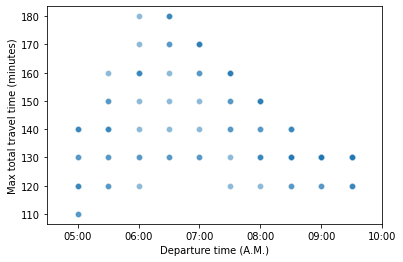

In [4]:
ax = sns.scatterplot(data=df, x='depart_datetime_nodate', y='travel_time_max_minutes', alpha=0.5)
ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])

ax.set_xlabel('Departure time (A.M.)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_ylabel('Max total travel time (minutes)')

Ok, so annywhere from two to three hours - that checks out. Already here you can see one of the key points of this whole thing: the range of possible durations for the same departure time is huge! For example, leaving at 6:30 am can take anywhere from 130 to 180 minutes - that's an hour difference for the same departure time!

Next up, let's see which route seems to be faster:

Text(0, 0.5, 'I-93 S travel time (min)')

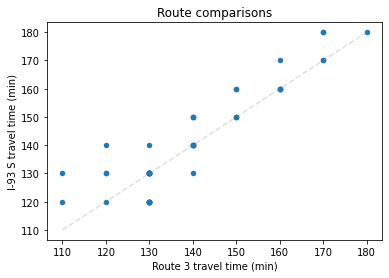

In [5]:
route_df = df.pivot(
    index='depart_datetime', columns='route', values='travel_time_max_minutes'
)

fig, ax = plt.subplots()
ax.plot([110, 180], [110, 180], color='gray', linestyle='--', alpha=0.25)
ax = route_df.plot(kind='scatter', x='route 3', y='93', ax=ax)

ax.set_title('Route comparisons')
ax.set_xlabel('Route 3 travel time (min)')
ax.set_ylabel('I-93 S travel time (min)')

Interesting, this data seems to indicate that the routes are roughly equivalent but the I-93 route often takes longer than going on Route 3. While I see how a computer would think this, as a human it really doesn't check out.

What I think might be going on here is that I-93 has more predictable traffic than Route 3, both in terms of locations and amount, and so its estimates are taking into account that traffic while the Route 3 estimates aren't able to. 
Perhaps it _would_ make sense for Google's algorithm to incorporate its confidence in the amount & location of traffic when it gives you estimates for travel _in the future_. As a computer, the data is very clear: 93 south has traffic in the same spots every single day. It's easy to measure and very consistent, and therefore very very predictable. Route 3, on the other hand, _theoretically_ should have less traffic because it's _not_ the main thoroughfare into Boston - the route goes through Nashua and then veers west to go around Boston before taking I-90 East back into Cambridge. Of course, though, there's always traffic or accidents on this route - it's just that maybe the traffic isn't always in the exact same spot and so the algorithm isn't conffident enough in it to incorporate it in its predictions. (Though if you ask me, that gnarly interesction has always been _predictably_ awful and Google always underestimes how much time it adds - it should have been incorporated into the algorithm by now! Come on neural nets, get it together!)

Anyway, let's get directly to our question: is it possible to reliably arrive at a reasonable morning working time, or does the Boston traffic time warp make that a physical impossibility?

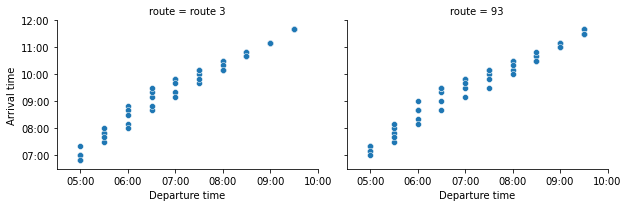

In [6]:
g = sns.FacetGrid(data=df, col='route', aspect=1.5)

g.map(sns.scatterplot, 'depart_datetime_nodate', 'arrival_time_max_nodate')

for ax in g.axes.flatten():
    ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])
    ax.set_ylim([pd.to_datetime('2022-09-08 06:30:00'), pd.to_datetime('2022-09-08 12:00:00')])
#    ax.legend(loc='lower right')

    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    
    ax.set_xlabel('Departure time')
    if ax.get_ylabel():
        ax.set_ylabel('Arrival time')

Looks like the two routes are basically the same. Given that I've learned my lesson about route 3 from my recent experience, and that I-93 is a much more pleasant drive, I'll focus on that for the rest of this deep dive into the time warp. I'm also only looking at the maximum estimated time provided by Google, since we know from personal experience that even that maximum is often an underestimate.

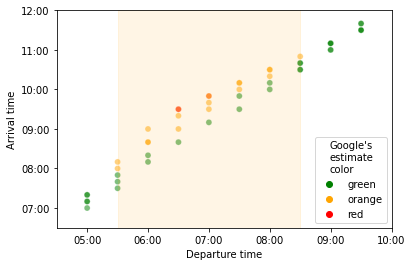

In [7]:
def format_time_axes(ax):
    ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_xlabel('Departure time')
    ax.set_ylim([pd.to_datetime('2022-09-08 06:30:00'), pd.to_datetime('2022-09-08 12:00:00')])
    ax.yaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    ax.set_ylabel('Arrival time')
    return None        

def basic_scatter(
    df, x='depart_datetime_nodate', y='arrival_time_max_nodate',
    format_y=True, format_x=True
):

    ax = sns.scatterplot(
        data=df.query('route == "93"'), x=x, y=y,
        hue='color', alpha=0.5,
        palette={'red': 'red', 'green': 'green', 'orange': 'orange'}
    )

    ax.legend(loc='lower right', title="Google's\nestimate\ncolor")
    
    format_time_axes(ax)
    
    return ax

ax = basic_scatter(df)

ax.fill_between(
    x=[pd.to_datetime('2022-09-08 05:30:00'), pd.to_datetime('2022-09-08 08:30:00')],
    y1=[pd.to_datetime('2022-09-08 12:00:00'), pd.to_datetime('2022-09-08 12:00:00')],
    alpha=0.1, color='orange'
)

Basically, leaving home any time between 5:30 am and 8:30 am puts me in the Boston traffic time warp: a period of  unpredictable and highly variable traffic, when the trip can take a full hour more on a bad day than a good one. And despite Google's conservative estimates of the badness of traffic (at least based on the color of the arrival estimates they provide), you can see that the worst times for traffic also fall within the time warp period. 

We can look at the day-to-day variability using my favorite statistical method, eyeballing it (since each point is a day, it's the vertical spread between points), or by calculating it directly:

In [8]:
# Difference in max travel time between days
(df.groupby('depart_time')['travel_time_max_minutes'].max() 
 - df.groupby('depart_time')['travel_time_max_minutes'].min()
).reset_index(name='max_and_min_days_delta')

,depart_time,max_and_min_days_delta
0,5:00 AM,30.0
1,5:30 AM,40.0
2,6:00 AM,60.0
3,6:30 AM,50.0
4,7:00 AM,40.0
5,7:30 AM,40.0
6,8:00 AM,30.0
7,8:30 AM,20.0
8,9:00 AM,10.0
9,9:30 AM,10.0


During the Boston traffic time warp, your commute can differ by up to an hour depending on which day you leave. Outside of the time warp, though, it's pretty consistent.

Taking this further - leaving on a bad day might get you to Boston at the same time as leaving a full hour later on a good day. (I'll say it again: leaving at 7:30 am on a bad day means you arrive at the same time as leaving at 8:30 on a good day :sob: - think of the extra hour of sleep you could have had!!) You can see this because the worst arrival time for a given departure time is the same arrival time as the best arrival time for a departure time an hour later - in other words, the highest dot for a given departure time is at the same vertical level as the lowest dot for a departure time that's an hour later.

Outside of the time warp, in contrast, travel time to Boston is quite stable at around max two hours. But within the time period, the max travel time to Boston can get up to 3 hours depending on the day of the week. And that's not even counting accidents, road work, or whatever else Google can't predict! 

Let's see if Google's own estimates recapitulate the high variance during the time warp.

In [9]:
df['delta_min_max'] = df['arrival_time_max_nodate'] - df['arrival_time_min_nodate']
df.query('route == "93"').groupby('depart_datetime_nodate')['delta_min_max'].describe()['mean']

depart_datetime_nodate
2022-09-08 05:00:00   00:36:00
2022-09-08 05:30:00   00:42:00
2022-09-08 06:00:00   00:54:00
2022-09-08 06:30:00   00:58:00
2022-09-08 07:00:00   00:52:00
2022-09-08 07:30:00   00:44:00
2022-09-08 08:00:00   00:40:00
2022-09-08 08:30:00   00:32:00
2022-09-08 09:00:00   00:30:00
2022-09-08 09:30:00   00:28:00
Name: mean, dtype: timedelta64[ns]

Text(0, 0.5, 'Difference between earliest\nand latest arrival times (minutes)')

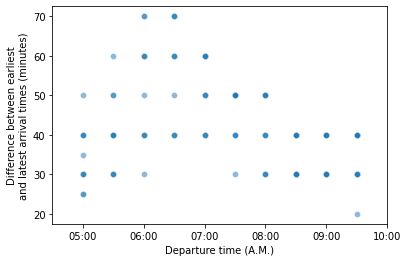

In [10]:
df['delta_min_max_float'] = df['delta_min_max'] / pd.Timedelta(minutes=1)

ax = sns.scatterplot(data=df, x='depart_datetime_nodate', y='delta_min_max_float', alpha=0.5)
ax.set_xlim([pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')])

ax.set_xlabel('Departure time (A.M.)')
ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))

ax.set_ylabel('Difference between earliest\nand latest arrival times (minutes)')

Yep, you can see that the range between the earliest and latest estimated arrival times that Google provides reflects the range we see when we look at the day-to-day variability in the latest arrival time. Google seems to have a narrower time warp though, with things really only getting dicey from 5:30 to 8 am. I've been caught by this before, flipping back and forth between different departure times the night before I have to head into Boston, simultaneously calculating how few hours of sleep I'm gonna get with the likelihood of there being traffic and my own confidence in Google's optimistic estimates. 

Ok great so the time warp exists, but that doesn't solve my problem of still needing to drive into Boston sometimes.  Let's say I'd like to arrive to work between 9:30 and 10:30 am, what does my commute look like then?

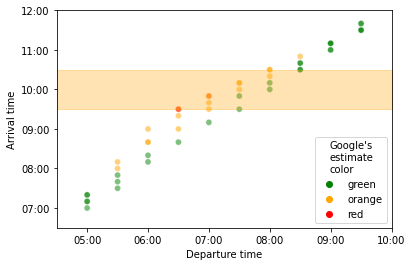

In [11]:
ax = basic_scatter(df)

ax.fill_between(
    x=[pd.to_datetime('2022-09-08 04:30:00'), pd.to_datetime('2022-09-08 10:00:00')],
    y1=[pd.to_datetime('2022-09-08 09:30:00'), pd.to_datetime('2022-09-08 09:30:00')],
    y2=[pd.to_datetime('2022-09-08 10:30:00'), pd.to_datetime('2022-09-08 10:30:00')],
    alpha=0.3,
    color='orange'
)


Woof - on the absolute worst day, getting to Boston at 9:30 am means I'd have to leave at 6:30 am. But on the best day, I could leave at 7:30 am. To make the best use of my time and not get stuck in the time warp, I should really try to leave home at 8:30  or 9, which means I shouldn't schedule anything important until after 11 am. 

However, I usually end up leaving around 8 am because arriving at 11 am is a little bit too late and too disruptive to my workday. Leaving at 8 am is sort of the balance point for me where I'm comfortable gambling on it being a good day (and thus getting to Boston early enough to enjoy a leisurely coffee before my 11 am meetings), but not so early that if I get stuck in traffic I'll be very annoyed at all the time I wasted. Also, two and half hours doesn't feel too too bad for a commute in, but only because I don't do it very often. From this analysis, though, it does seem like leaving at 8:30 am is probably a better bet - I don't get to Boston that much later, but the day-to-day variability in my commute will be lower, thus leading to hopefully less frustration.

Anyway, I already mostly knew this - scheduling anything in Boston before 11 am is a gamble unless I'm willing to leave super early. I didn't really realize just how early I'd need to leave - I would have guessed 6 am was fine but no, it's 5 am or bust.

In conclusion, Boston morning traffic sucks and feels like a time warp, which the data confirms is a valid feeling to have. Google's estimates are surprisingly optimistic, with the maximum arrival time corresponding best with my lived experience. (Note to self: ignore the earliest estimated time from now on). Also, Google thinks that Route 3 and I-93 are basically the same, but my experience shows that to not be true. Maybe Google needs to incorporate an "emotional frustration" parameter into their recommendation algorithm, which includes some weights related to the daily variability in the traffic as well as how well Google's estimates actually perform. Finally, leaving between 5:30 and 9 am means that my commute is unpredictable and could potentially suck a lot. That means that trying to get into Boston between 7:30 and 10:30 am sucks, and I shouldn't schedule any important meetings during that time period if I don't want to have to leave super early. So long as my first meetings are after 11 am, 8:30 am seems to be the optimal time to leave, balancing the potential benefit of getting into Boston early enough to grab a coffee with the slight chance of hitting a bad traffic day and getting a little stuck in the time warp.

Next time, I'd love to do this analysis but stop just north of Boston and see what proportion of all this chaos is caused by the last like 5 miles of the trip vs the other 55. 